# Frozen Lake

Apply and compare SARSA(lambda), Q(lambda), DynaQ and Trajectory sampling agents on the Frozen Lake (FL) environment using a discount factor gamma=0.99. For the comparison, you can plot only states (0, 6, 10). Get also the optimal state-value functions using Dynamic Programming.

Remember: FL is a simple grid-world environment. It has 16 states and 4 actions. The goal of the agent is to go from a start location to a goal location while avoiding falling into holes. All transitions landing on the goal state  provide a +1 reward, while every other transition in the entire grid world provides no reward. The challenge is that the surface of the lake is frozen, and therefore slippery. So actions have stochastic effects, and the agent moves only a third of the time as intended. The other two-thirds is split evenly in orthogonal directions.

FL is a more challenging environment than Slippery Walk environment. Therefore, one of the most important changes you need to make is to increase the number of episodes the agent interacts with the environment. While in the Slippery Walk environment we allow the agent to interact for only 3.000 episodes, in the FL environment, let your agent gather experience for 10.000 episodes.

1 - Import the FrozenLake environment and extract it MPD dynamics.

In [2]:
# YOUR CODE HERE

# You can get the environment from Gymnasium 'FrozenLake-v1’; 
# In order to visually plot the environment you can import it 
# using render_mode="rgb_array"
# You can also import the actions LEFT, DOWN, RIGHT, UP from gym
# Finally, you can import the transition probabilities P from gym

import gymnasium as gym

LEFT, DOWN, RIGHT, UP = range(4)
frozen_lake = gym.make('FrozenLake-v1', render_mode="rgb_array")

2- Create a random policy as a baseline

In [3]:
# YOUR CODE HERE

# You have to create a function that get in input a state and provide a random action

import numpy as np

def pi_random(s):
    return np.random.choice(4);

3 - Show the policy in action by rendering the environment several times after different decisions from the random policy:

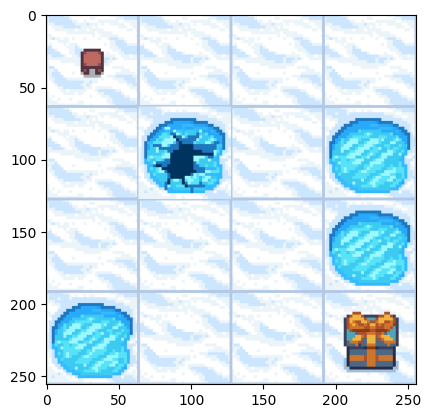

Step : 22 Action:  0


In [4]:
# YOUR CODE HERE

# You have to use a while loop in order to provide the current state to 
# the policy and then make a step in the environment using the action 
# provided by the policy. 
# Try to create a function (to be called "show_policy") 
# to be reused with other policies later.
# Hints: env.render() provides you an array representing 
# an image of the environment; plt.imshow() can be used to visualize 
# the image on the screen.

import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

def show_policy(env, pi, n_episodes=1, max_steps=50):
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        steps = 0;
        while not done and steps < max_steps:
            action = pi(state);
            state, reward, done, _, _ = env.step(action)
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.show()
            steps += 1
            print('Step :',steps, 'Action: ', action)
            time.sleep(0.5)

show_policy(frozen_lake, pi_random)

4 - Solve the environment using Dynamic Programming:

In [5]:
#  YOUR CODE HERE

# Copy the value iteration algorithm from the lecture notes.

def value_iteration(env, gamma=1.0, theta=1e-10):

    # we need to unwrap the environment to access its 
    # internal dynamic
    dynamics = env.unwrapped.P;
    
    # initialize a state-value function
    v = np.zeros(len(dynamics))
    
    while True:
        q = np.zeros((len(dynamics), len(dynamics[0])))
        
        # for every transition of every action in every state, we...
        for s in range(len(dynamics)):
            for a in range(len(dynamics[s])):
                for prob, next_state, reward, done in dynamics[s][a]:    
                    # ...calculate the action-value function
                    q[s][a] += prob * (reward + gamma * v[next_state])
        
        # After each sweep over the state space, make sure the state-value function keeps changing, 
        # otherwise, we found the optimal state-value function and should break out
        if np.max(np.abs(v - np.max(q, axis=1))) < theta:
            break;
            
        # we don’t need a separate policy-improvement phase
        v = np.max(q, axis=1)
    
    # only at the end, we extract the optimal policy
    def pi(s): 
        return np.argmax(q[s])  
    
    return v, pi

In [7]:
# YOUR CODE HERE

# Solve the problem using the algorithm and exploiting the MDP dynamics

optimal_v, optimal_pi = value_iteration(frozen_lake, gamma=0.99)

5 - Print the values of the optimal state-value function

In [8]:
# YOUR CODE HERE

# Copy the print_state_value_function function from the lecture notes and use it to
# print the state-value function for the best policy

def print_state_value_function(v, env):
    dynamics = env.unwrapped.P;
    n_cols = 4;
    print("State-value function:");
    for s in range(len(dynamics)):
        if np.all([done for action in dynamics[s].values() for _, _, _, done in action]):
            print(" X  ", end="\t");
        else:
            print(np.round(v[s], 2), end="\t");
        if (s+1)%n_cols==0: 
            print(" ");

print_state_value_function(optimal_v, frozen_lake)

State-value function:
0.54	0.5	0.47	0.46	 
0.56	 X  	0.36	 X  	 
0.59	0.64	0.62	 X  	 
 X  	0.74	0.86	 X  	 


6 - Implement the SARSA(lambda) algorithm and use it against the FL environment

In [9]:
# YOUR CODE HERE

# Copy the decay_schedule function from the lecture notes

def decay_schedule(init_value, min_value, decay_steps, max_steps):

    # calculate the number of the remaining steps after the decay
    rem_steps = max_steps - decay_steps;

    # logspace returns numbers spaced evenly on a log scale
    # base^start is the starting value of the sequence,
    # base^stop is the final value of the sequence
    # num is the number of values to generate
    # base is the base of the log space
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10);

    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min());

    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value;

    # repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_steps), 'edge');

    return values;

In [10]:
# YOUR CODE HERE

# Copy the decay_discounts function from the lecture notes

def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

In [11]:
# YOUR CODE HERE

# Copy the select_action function from the lecture notes

def select_action(state, q, epsilon=0.1):

    # if the random number is greater than epsilon, 
    if np.random.uniform() > epsilon:
        # pick the action with the highest Q value
        action = np.argmax(q[state]);
    else:
        # otherwise, pick a random action
        action = np.random.randint(len(q[0]));

    return action;

In [28]:
# YOUR CODE HERE

# Copy the sarsa_lambda function from the lecture notes and modify it in order to ask the environment the number
# of states and actions following the Gymnasium interface (.n), and extract the id of the starting state from the first 
# output of the reset() function.

def sarsa_lambda(env, gamma=0.99, 
                 init_alpha=0.5, min_alpha=0.01, 
                 init_epsilon=1.0, min_epsilon=0.1, 
                 lambda_=0.5, replacing_traces=True,
                 decay_episodes=2500, n_episodes=10000):
    
    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the current estimate of the action-value function
    q = np.zeros((env.observation_space.n, env.action_space.n), dtype=float);

    # eligibility traces
    E = np.zeros((env.observation_space.n, env.action_space.n), dtype=float);

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space.n), dtype=float);

    # the episode loop
    for e in range(n_episodes):
      
        # every new episode, set the eligibility of every state to zero
        E.fill(0);

        # # we start episode by resetting the environment and the done flag
        state, done = env.reset()[0], False;

        # select the action (perhaps exploratory) for the initial state
        action = select_action(state, q, epsilons[e]);
        
        # repeat until we hit a terminal state
        while not done:
            
            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated):
                done = True;
            
            # obtain the action for the next step
            next_action = select_action(next_state, q, epsilons[e]);

            # calculate the target using that next state-action pair
            sarsa_lambda_target = reward + gamma * q[next_state][next_action];
            
            # calculate the error  
            sarsa_lambda_error = sarsa_lambda_target - q[state][action];
            
            # increment the state-action pair trace, 
            # and clip it to 1 if it’s a replacing trace
            if replacing_traces: 
                E[state].fill(0);
            E[state][action] = E[state][action] + 1;
            if replacing_traces: 
                E.clip(0, 1, out=E);
            
            # apply the error to all eligible state-action pairs at once
            # even though we’re using the entire q-table, E will be mostly 0, 
            # and greater than zero for eligible pairs
            q = q + alphas[e] * sarsa_lambda_error * E;
            
            # decay the eligibility matrix
            E = lambda_ * E;
            
            # update state and action for the next step
            state, action = next_state, next_action;
        
        # extract the state-value function   
        v = np.max(q, axis=1);

        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);

        # save values for post analysis   
        v_track[e] = v;
    
    return q, v, pi, v_track;

In [29]:
# YOUR CODE HERE

# Apply sarsa(lambda) for 10.000 episodes ans gamma = 0.99

q_sarsa_lambda, v_sarsa_lambda, pi_sarsa_lambda, v_track_sarsa_lambda = sarsa_lambda(frozen_lake);

7 - Plot the state-value functions for states (0, 6, 10) for SARSA(lambda) and compare with the optimal values. Than observe how the agent struggle to estimate the optimal state-value function. 

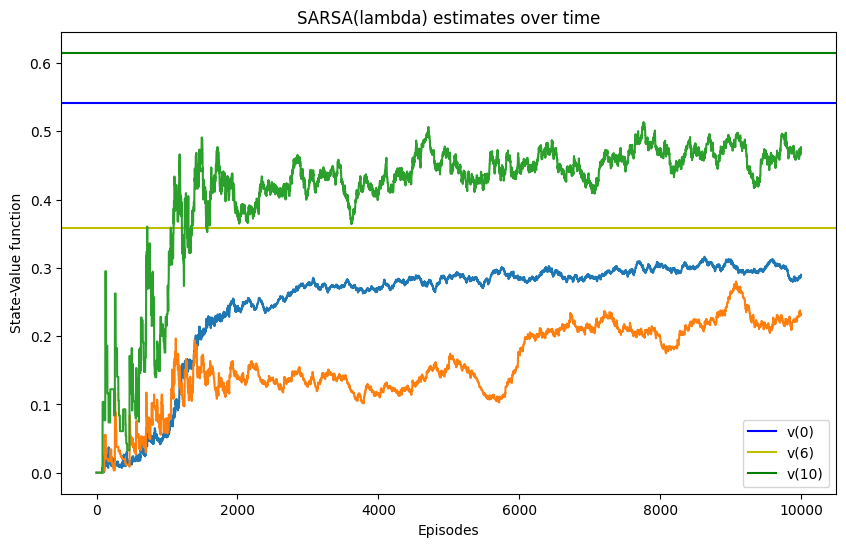

In [31]:
# YOUR CODE HERE

# import matplotlib.pyplot as plt and plot the V_track_sarsa_lambda for each episode for states 0, 6 and 10
# draw a horizontal line for the optimal_V for states 0, 6 and 10

import matplotlib.pyplot as plt

legends = ['v(0)','v(6)','v(10)'];
plt.figure(figsize=(10,6));
plt.title('SARSA(lambda) estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.axhline(y=optimal_v[0], color='b', linestyle='-');
plt.axhline(y=optimal_v[6], color='y', linestyle='-');
plt.axhline(y=optimal_v[10], color='g', linestyle='-');
plt.plot(v_track_sarsa_lambda[:,[0,6,10]]);
plt.legend(legends);
plt.show();

8 - Implement the Q(lambda) algorithm and use it against the FL environment

In [52]:
# YOUR CODE HERE

# Copy the q_lambda function from the lecture notes and modify it in order to ask the environment the number
# of states and actions following the Gymnasium interface (.n) and extract the id of the starting state from the first 
# output of the reset() function.

def q_lambda(env, gamma=0.99, 
             init_alpha=0.5, min_alpha=0.01, 
             init_epsilon=1.0, min_epsilon=0.1, 
             lambda_=0.5, replacing_traces=True,
             decay_episodes=2500, n_episodes=10000):
    
    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the current estimate of the action-value function
    q = np.zeros((env.observation_space.n, env.action_space.n), dtype=float);
        
    # eligibility traces
    E = np.zeros((env.observation_space.n, env.action_space.n), dtype=float);

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space.n), dtype=float);
    
    # the episode loop 
    for e in range(n_episodes):
        
        # every new episode, set the eligibility of every state to zero
        E.fill(0);
        
        # we start episode by resetting the environment and the done flag
        state, done = env.reset()[0], False;
        
        # notice: we are preselecting the action as in SARSA, (we didn’t do that in Q-learning) 
        # this is because we need to check whether our next action is greedy for deciding
        # to decay the eligibility trace
        action = select_action(state, q, epsilons[e])
        
        # repeat until we hit a terminal state
        while not done:
            
            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated):
                done = True;
            
            # select the next_action SARSA-style
            next_action = select_action(next_state, q, epsilons[e])
            
            # use it to verify that the action on the next step 
            # will still come from the greedy policy
            next_action_is_greedy = q[next_state][next_action] == q[next_state].max()

            # still calculate the target as in regular Q-learning, using the max
            q_lambda_learning_target = reward + gamma * q[next_state].max();
            
            # and use the target to calculate TD error
            q_lambda_learning_error = q_lambda_learning_target - q[state][action];
            
            # increment the state-action pair trace, 
            # and clip it to 1 if it’s a replacing trace
            if replacing_traces: 
                E[state].fill(0);
            E[state][action] = E[state][action] + 1
            if replacing_traces: 
                E.clip(0, 1, out=E);
            
            # as before, we multiply the entire eligibility trace matrix 
            # by the error and the learning rate corresponding to episode e, 
            q = q + alphas[e] * q_lambda_learning_error * E
            
            # if the action we’ll take on the next state (which we already selected) is a greedy action, 
            # then we decay the eligibility matrix as usual, otherwise, we must reset 
            # the eligibility matrix to zero because we’ll no longer be learning about the greedy policy
            if next_action_is_greedy:
                E =  lambda_ * E;
            else:
                E.fill(0);
            
            # update state and action for the next step
            state, action = next_state, next_action

        # extract the state-value function   
        v = np.max(q, axis=1);

        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);
        
        # save values for post analysis  
        v_track[e] = v;

    return q, v, pi, v_track;

In [53]:
# YOUR CODE HERE

# Apply q(lambda) for 10.000 episodes ans gamma = 0.99

q_ql_lambda, v_ql_lambda, pi_ql_lambda, v_track_ql_lambda = q_lambda(frozen_lake);

9 - Plot the state-value functions for states (0, 6, 10) for Q(lambda) and compare with the optimal values. Than observe as Q(lambda) agent is moving the estimates of the optimal state-value function toward the true values, unlike SARSA(lambda). Now, to be clear, this is a matter of the number of steps, also SARSA(lambda) would converge to the true values if given more episodes.

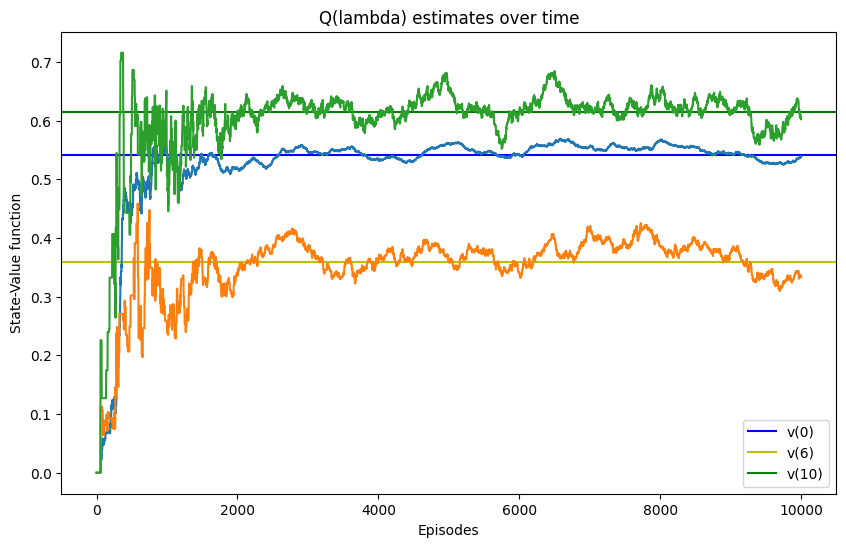

In [54]:
# YOUR CODE HERE

# import matplotlib.pyplot as plt and plot the V_track_q_lambda for each episode for states 0, 6 and 10
# draw a horizontal line for the optimal_V for states 0, 6 and 10

plt.figure(figsize=(10,6));
plt.title('Q(lambda) estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.axhline(y=optimal_V[0], color='b', linestyle='-');
plt.axhline(y=optimal_V[6], color='y', linestyle='-');
plt.axhline(y=optimal_V[10], color='g', linestyle='-');
plt.plot(v_track_ql_lambda[:,[0,6,10]]);
plt.legend(legends);
plt.show();

10 - Implement the DynaQ algorithm and use it against the FL environment.

In [40]:
# YOUR CODE HERE

# Copy the dyna_q function from the lecture notes and modify it in order to ask the environment the number
# of states and actions following the Gymnasium interface (.n) and extract the id of the starting state from the first 
# output of the reset() function.

def dyna_q(env, gamma=0.99,
           init_alpha=0.5, min_alpha=0.01, 
           init_epsilon=1.0, min_epsilon=0.1, 
           n_planning=3,
           decay_episodes=2500, n_episodes=10000):
    
    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the current estimate of the action-value function
    q = np.zeros((env.observation_space.n, env.action_space.n), dtype=float);

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space.n), dtype=float);

    # create a function to keep track of the transition function
    # and another one to keep track of the reward signal.
    transitions = np.zeros((env.observation_space.n, env.action_space.n, env.observation_space.n), dtype=int);
    rewards = np.zeros((env.observation_space.n, env.action_space.n, env.observation_space.n), dtype=float);

    # create a list to save copies of the model and of the planning 
    # for offline analysis
    transitions_track = [];
    planning_track = [];
    
    # the episode loop
    for e in range(n_episodes):
                   
        # we start episode by resetting the environment and the done flag
        state, done = env.reset()[0], False;
        
        # repeat until we hit a terminal state
        while not done:
                   
            # select the action, as in Q-learning       
            action = select_action(state, q, epsilons[e]);
                   
            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated):
                done = True;

            # start learning the model 
            # increment the transition count for the state-action-next_state triplet 
            transitions[state][action][next_state] += 1;
            
            # calculate an incremental mean of the reward signal
            # and use it to learn the reward signal
            difference = reward - rewards[state][action][next_state];
            rewards[state][action][next_state] += (difference / transitions[state][action][next_state]);

            # calculate the target as usual in Q-learning!
            # (off-policy, using the max)
            dyna_target = reward + gamma * q[next_state].max();
            
            # calculate the error 
            dyna_error = dyna_target - q[state][action];
            
            # update the action-value function
            q[state][action] = q[state][action] + alphas[e] * dyna_error;

            # get into the planning steps, first back up the next state variable      
            backup_next_state = next_state;
            
            # planning loop
            for _ in range(n_planning):
                   
                # make sure there have been updates to the Q-function before, 
                # otherwise, there’s not much to plan
                if q.sum() == 0: 
                    break;

                # select a state from a list of states already visited by 
                # the agent in experience   
                visited_states = np.where(np.sum(transitions, axis=(1, 2)) > 0)[0];
                state = np.random.choice(visited_states);

                # then select an action that has been taken on that state   
                actions_taken = np.where(np.sum(transitions[state], axis=1) > 0)[0];
                action = np.random.choice(actions_taken);

                # use the transitions to calculate probabilities of a next state 
                # and then a next state   
                probs = transitions[state][action]/transitions[state][action].sum();
                next_state = np.random.choice(np.arange(env.observation_space.n), size=1, p=probs)[0];
                
                # use the rewards model as the reward
                reward = rewards[state][action][next_state];

                # save the plannig decistion for offline analysis
                planning_track.append((state, action, reward, next_state));

                # update the Q-function using that simulated experience!    
                dyna_target = reward + gamma * q[next_state].max();
                dyna_error = dyna_target - q[state][action];
                q[state][action] = q[state][action] + alphas[e] * dyna_error;
                        
            # at the end of the planning, set the state as the next state
            state = backup_next_state;
        
        # extract the state-value function   
        v = np.max(q, axis=1);

        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);

        # save the value functions and the transitions model for analysis 
        v_track[e] = v;
        transitions_track.append(transitions.copy());

    return q, v, pi, v_track, transitions_track, np.array(planning_track);

In [41]:
# YOUR CODE HERE

# Apply DynaQ for 10.000 episodes and gamma = 0.99

q_dyna, v_dyna, pi_dyna, v_track_dyna, transitions_track_dyna, planning_dyna = dyna_q(frozen_lake)

11 - Plot the state-value functions for states (0, 6, 10) for DynaQ and compare with the optimal values. 

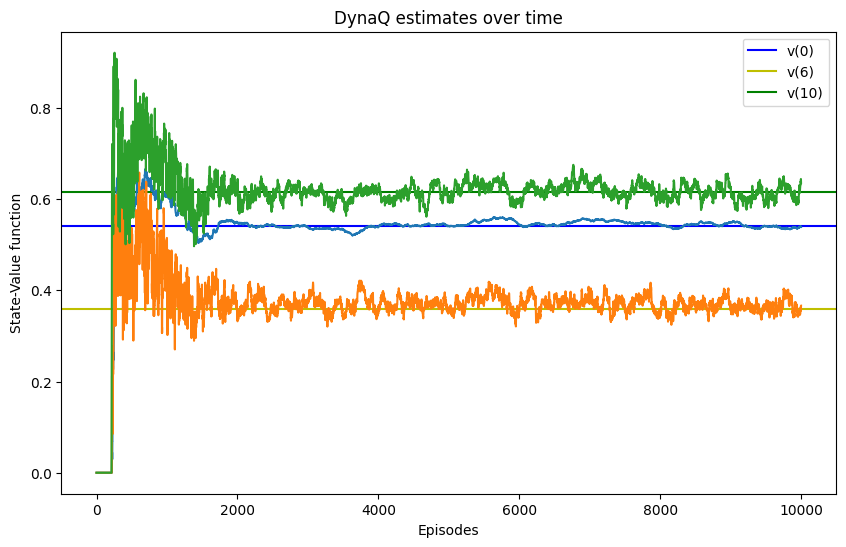

In [42]:
# YOUR CODE HERE

# import matplotlib.pyplot as plt and plot the V_track_dq for each episode for states 0, 6 and 10
# draw a horizontal line for the optimal_V for states 0, 6 and 10

plt.figure(figsize=(10,6));
plt.title('DynaQ estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.axhline(y=optimal_V[0], color='b', linestyle='-');
plt.axhline(y=optimal_V[6], color='y', linestyle='-');
plt.axhline(y=optimal_V[10], color='g', linestyle='-');
plt.plot(v_track_dyna[:,[0,6,10]]);
plt.legend(legends);
plt.show();

12 - Implement the Trajectory Sampling algorithm and use it against the FL environment.

In [49]:
# YOUR CODE HERE

# Copy the trajectory_sampling function from the lecture notes and modify it in order to ask the environment the number
# of states and actions following the Gymnasium interface (.n) and extract the id of the starting state from the first 
# output of the reset() function.

def trajectory_sampling(env, gamma=0.99, 
                        init_alpha=0.5, min_alpha=0.01, 
                        init_epsilon=1.0, min_epsilon=0.1, 
                        n_planning=3, 
                        decay_episodes=2500, n_episodes=10000):

    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the current estimate of the action-value function
    q = np.zeros((env.observation_space.n, env.action_space.n), dtype=float);

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space.n), dtype=float);

    # create a function to keep track of the transition function
    # and another one to keep track of the reward signal.
    transitions = np.zeros((env.observation_space.n, env.action_space.n, env.observation_space.n), dtype=int);
    rewards = np.zeros((env.observation_space.n, env.action_space.n, env.observation_space.n), dtype=float);

    # create a list to save copies of the model and of the planning 
    # for offline analysis
    transitions_track = [];
    planning_track = [];

    # the episode loop
    for e in range(n_episodes):
                   
        # we start episode by resetting the environment and the done flag
        state, done = env.reset()[0], False;
        
        # repeat until we hit a terminal state
        while not done:

            # select the action, as in Q-learning  
            action = select_action(state, q, epsilons[e])

            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated):
                done = True;
            
            # start learning the model 
            # increment the transition count for the state-action-next_state triplet 
            transitions[state][action][next_state] += 1;

            # calculate an incremental mean of the reward signal
            # and use it to learn the reward signal
            difference = reward - rewards[state][action][next_state];
            rewards[state][action][next_state] += (difference / transitions[state][action][next_state]);

            # calculate the target as usual in Q-learning!
            # (off-policy, using the max)
            ts_target = reward + gamma * q[next_state].max();
            
            # calculate the error 
            ts_error = ts_target - q[state][action];

            # update the action-value function
            q[state][action] = q[state][action] + alphas[e] * ts_error;
            
            # get into the planning steps, first back up the next state variable 
            backup_next_state = next_state;

            # planning loop
            for _ in range(n_planning):
                
                # make sure there have been updates to the Q-function before, 
                # otherwise, there’s not much to plan
                if q.sum() == 0: 
                    break;

                # select the action following the behavioral policy or from the greedy policy
                # action = select_action(state, q, epsilons[e]);
                action = q[state].argmax();
                    
                # if we haven’t experienced the transition, 
                # planning would be a mess, so break out
                if not transitions[state][action].sum(): 
                    break;

                # otherwise, get the probabilities of next_state and sample 
                # the model accordingly, as in DynaQ
                probs = transitions[state][action]/transitions[state][action].sum();
                next_state = np.random.choice(np.arange(env.observation_space.n), size=1, p=probs)[0];
                    
                # get the reward as prescribed by the reward-signal model, as in DynaQ
                reward = rewards[state][action][next_state];

                # save the plannig decistion for offline analysis
                planning_track.append((state, action, reward, next_state));

                # update the Q-function using that simulated experience!      
                ts_target = reward + gamma * q[next_state].max();
                ts_error = ts_target - q[state][action];
                q[state][action] = q[state][action] + alphas[e] * ts_error;

                # we update the state variable before we loop and 
                # continue the planning steps
                state = next_state;

            # at the end of the planning, set the state as the next state
            state = backup_next_state;
        
        # extract the state-value function 
        v = np.max(q, axis=1);
        
        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);
            
        # save the value functions and the transitions model for analysis 
        v_track[e] = v;
        transitions_track.append(transitions.copy());
    
    return q, v, pi, v_track, transitions_track, np.array(planning_track);

In [50]:
# YOUR CODE HERE

# Apply trajectory_sampling for 10.000 episodes ans gamma = 0.99

s, v_ts, pi_ts, v_track_ts, transitions_track_ts, planning_ts = trajectory_sampling(frozen_lake);

13 - Plot the state-value functions for states (0, 6, 10) for Trajectory Sampling and compare with the optimal values. 

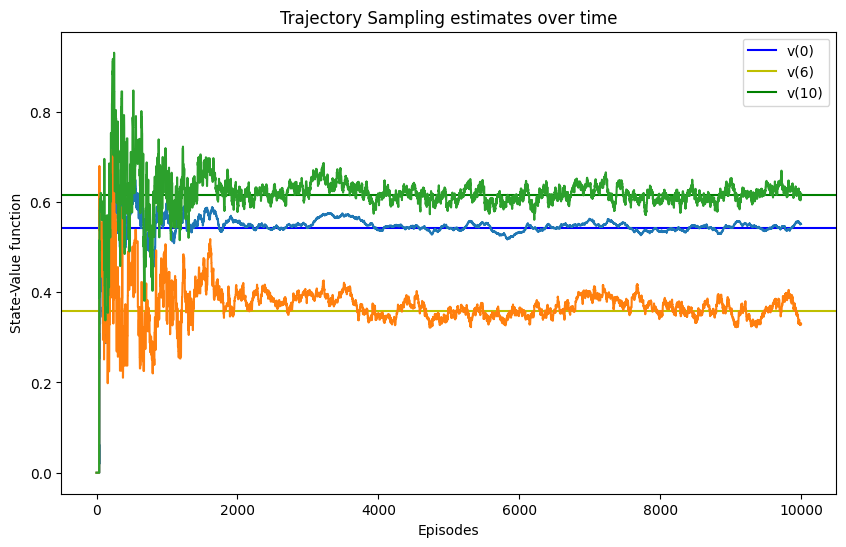

In [51]:
# YOUR CODE HERE

# import matplotlib.pyplot as plt and plot the V_track_ts for each episode for states 0, 6 and 10
# draw a horizontal line for the optimal_V for states 0, 6 and 10

plt.figure(figsize=(10,6));
plt.title('Trajectory Sampling estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.axhline(y=optimal_V[0], color='b', linestyle='-');
plt.axhline(y=optimal_V[6], color='y', linestyle='-');
plt.axhline(y=optimal_V[10], color='g', linestyle='-');
plt.plot(v_track_ts[:,[0,6,10]]);
plt.legend(legends);
plt.show();

14 - Plot the state-value function mean absolute error for all the methods.

In [57]:
# YOUR CODE HERE

# Copy the moving average function from the lecture notes

def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

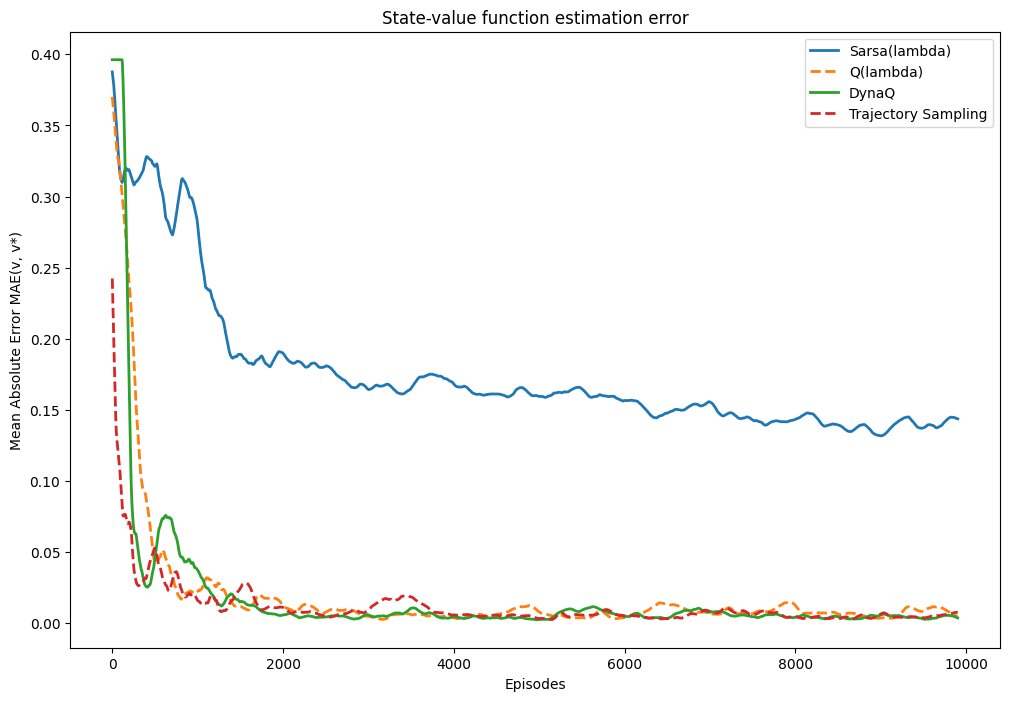

In [60]:
# YOUR CODE HERE

# plot the moving average of the absolute error between the optimal_v 
# and the v for each algorithm

plt.figure(figsize=(12,8));
plt.plot(moving_average(np.mean(np.abs(v_track_sarsa_lambda - optimal_v), axis=1)), '-', linewidth=2, label='Sarsa(lambda)');
plt.plot(moving_average(np.mean(np.abs(v_track_ql_lambda - optimal_v), axis=1)), '--', linewidth=2, label='Q(lambda)');
plt.plot(moving_average(np.mean(np.abs(v_track_dyna - optimal_v), axis=1)), '-', linewidth=2, label='DynaQ');
plt.plot(moving_average(np.mean(np.abs(v_track_ts - optimal_v), axis=1)), '--', linewidth=2, label='Trajectory Sampling');
plt.legend(loc=1, ncol=1);
plt.title('State-value function estimation error');
plt.xlabel('Episodes');
plt.ylabel('Mean Absolute Error MAE(v, v*)');
plt.show();

11  - Show the optimal policy:

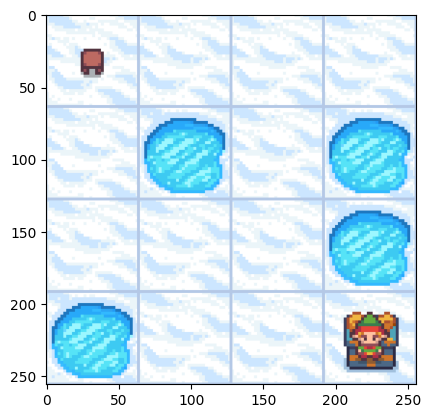

Step : 18 Action:  1


In [62]:
# YOUR CODE HERE

# You can reuse the "show_policy" function written before, 
# in order to show the optimal policy

show_policy(frozen_lake, pi_ql_lambda, n_episodes=1, max_steps=5009)